# Company Emails
---
We work with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

import ast

In [423]:
tuple_lst = []
with open('../datasets/email_prediction_edges.txt') as inp:
    for line in inp:
        values = ast.literal_eval(line)
        tuple_lst.append(values)
tuple_lst = tuple_lst[0]

G = nx.Graph()
G_nodes = (pd.read_csv('../datasets/email_prediction_nodes.csv', sep='\t').set_index('nodes'))
node_dict = G_nodes.to_dict('index').items()
G.add_nodes_from(node_dict)
G.add_edges_from(tuple_lst)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


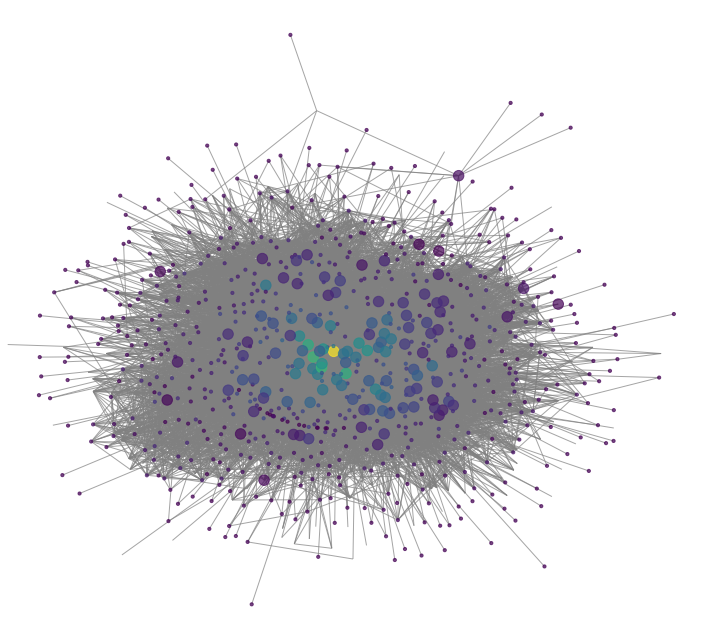

In [268]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,9))
node_color = [G.degree(v) for v in G]
node_size = [10+100*nx.get_node_attributes(G, 'ManagementSalary')[v] for v in G]
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos, node_size=node_size, node_color=node_color, alpha=0.7, with_labels=False, edge_color='.5')
plt.axis('off')
plt.tight_layout();

### Part 2A - Salary Prediction

Using network `G`, we identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, we need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



The predictions are given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric is the Area Under the ROC Curve (AUC).

In [360]:
def salary_predictions():
    
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    
    
    df = G_nodes.copy()
    
    
    df['Degree'] = pd.Series([G.degree(node) for node in G])
    
    degCent = nx.degree_centrality(G)
    df['Degree centrality'] = pd.Series([degCent[node] for node in G])

    df['Clustering coef'] = pd.Series([nx.clustering(G,node) for node in G])
    closeCent = nx.closeness_centrality(G, wf_improved=True)
    df['Closeness centrality'] = pd.Series([closeCent[node] for node in G])
    btwCent = nx.betweenness_centrality(G, normalized=True, endpoints=False)
    df['Betweenness centrality'] = pd.Series([btwCent[node] for node in G])
    
    
    df_train = df[pd.notna(df['ManagementSalary'])]
    df_test = df[np.isnan(df['ManagementSalary'])].copy()
    df_test.drop('ManagementSalary', axis=1, inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns!='ManagementSalary'], 
                                                        df_train['ManagementSalary'], 
                                                        random_state = 0)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    df_test_scaled = scaler.transform(df_test)

    clf = LogisticRegression(solver='liblinear', random_state=1).fit(X_train_scaled, y_train)
    rocScore = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1])
    
    return rocScore

salary_predictions()

0.9215932914046122

### Part 2B - New Connections Prediction

We predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [361]:
future_connections = pd.read_csv('../datasets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, we identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, we need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



The predictions are given as the probability of the corresponding edge being a future connection.

The evaluation metric is the Area Under the ROC Curve (AUC).

In [421]:
def new_connections_predictions():
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    
    
    non_edges_G = list(future_connections.index)
    
    df = pd.DataFrame(future_connections.copy())
    df['common neighbor'] = [len(list(nx.common_neighbors(G, e[0], e[1]))) for e in non_edges_G]
    
    df_train = df[pd.notna(df['Future Connection'])]
    df_test = df[np.isnan(df['Future Connection'])].copy()
    df_test.drop('Future Connection', axis=1, inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns!='Future Connection'], 
                                                        df_train['Future Connection'], 
                                                        random_state = 0)
    

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    df_test_scaled = scaler.transform(df_test)

    clf = LogisticRegression(solver='liblinear', random_state=1).fit(X_train_scaled, y_train)
    rocScore = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1])
    
    return rocScore


new_connections_predictions()